# Data

## Import libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from daftpy.daftmodel import (split_data, scores_statistics, metrics_regression, 
                              plot_learning_curves, compare_models, residuals)
#, transformer_estimator,residuals
from yellowbrick.regressor import ResidualsPlot
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor

import joblib

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## Load Data

In [3]:
data = pd.read_csv('data_available/selected_data.csv', sep=',')
data.shape 

(7344, 9)

**Predictors**

In [4]:
# Numeric features
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
#num_features.remove('longitude')
#num_features.remove('latitude')

# Categorical features
cat_features =  list(data.select_dtypes('object').columns)
cat_features.remove('city_district')

# Make DataFrames to present the features
num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

# Merge both DataFrames
feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,code
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


**Categorical Predictors Levels**

In [5]:
levels_type_house = data.type_house.unique()
levels_code = data.code.unique()
#levels_city_district = data.city_district.unique()

cat_feat_df['n_levels'] = [data.code.nunique(), data.type_house.nunique()]
cat_feat_df['sample'] = [levels_code[:5], levels_type_house]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,code,136,"[nan, W91, Y35, D08, D6W]"
1,type_house,2,"[house, nan, apartment]"


## Split Data

QUITAR LAS VARIABLES AL FINAL DEL NOTEBOOK ANTERIOR

In [6]:
features = [
    'price',
    'floor_area',
#    'views',
    'latitude',
    'longitude',
    'bedroom',
    'bathroom',
#    'sale_type',
    'type_house',
#    'postcode',
#    'state_district',
#    'county',
#    'city_district',
#    'road',
#    'place',
    'code',
#    'admin1',
#    'cities'
]

data = data[features].copy()
data.shape

(7344, 8)

In [7]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.15, 
                                              output='X_y_train_test',
                                              random_state=7)

X_train: (6242, 7) 
X_test: (1102, 7) 
y_train: (6242,) 
y_test: (1102,) 



# Metrics

We are going to use the following metrics to evaluate the models:

LaTeX

In [8]:
scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

Transformations

https://scikit-learn.org/stable/modules/preprocessing.html

# Models

## Baseline Model

In [9]:
baseline = data[['code', 'price']]

baseline = baseline.groupby(['code']).mean()
baseline.sort_values('price', ascending=False).head()

,price
code,
D06,1.047290e+06
A96,8.952080e+05
D04,8.162222e+05
A94,7.806413e+05
D02,7.420732e+05


## Multiple Linear Regression

We are going to use the `transformer_estimator` function to encoder categorical variables, transform numerical variables and input the median to numerical variables and fill with `None` categorical ones with missing values.

Then we will use the `scores_statistics` function to plot the metrics after do cross_validation.

In [11]:
lr_pipe_estimator = transformer_estimator(num_transformation='yeo-johnson', 
                                          levels_list=[levels_code, levels_type_house],
                                          regressor=LinearRegression(), 
                                          poly_degree=1)

scores_lr, scores_resume_lr = scores_statistics(estimator=lr_pipe_estimator, 
                                                scoring_dict=scoring, 
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                cv=5, 
                                                return_train_score=False)

r2 mean: 0.6385428821350709
r2 std: 0.014981942672871269 

MAE mean: -114580.15120890873
MAE std: 3636.8708339469317 

MAPE mean: -0.3663599460194195
MAPE std: 0.010837565199847273 

RMSE mean: -182425.7510863579
RMSE std: 12245.309214032713 



------------

------------

### Overfitting Analysis

Now we are plotting the metrics for the train and test sets. We will use the `metrics_regression` function to do that.

In [12]:
lr = lr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = lr.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = lr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6565418947723425
MAE: 111329.76419252346
MAPE: 0.35422605390252876
RMSE: 178186.41943349098

Performance on the test set:
 ----------
R²: 0.6056919434828945
MAE: 106990.12688294591
MAPE: 0.3594920018529949
RMSE: 160136.74861323944



### Residuals Diagnostic

The `residuals` function plots the actual values against the predicted ones in addition to the residuals. This will help us to understand how the model is working.

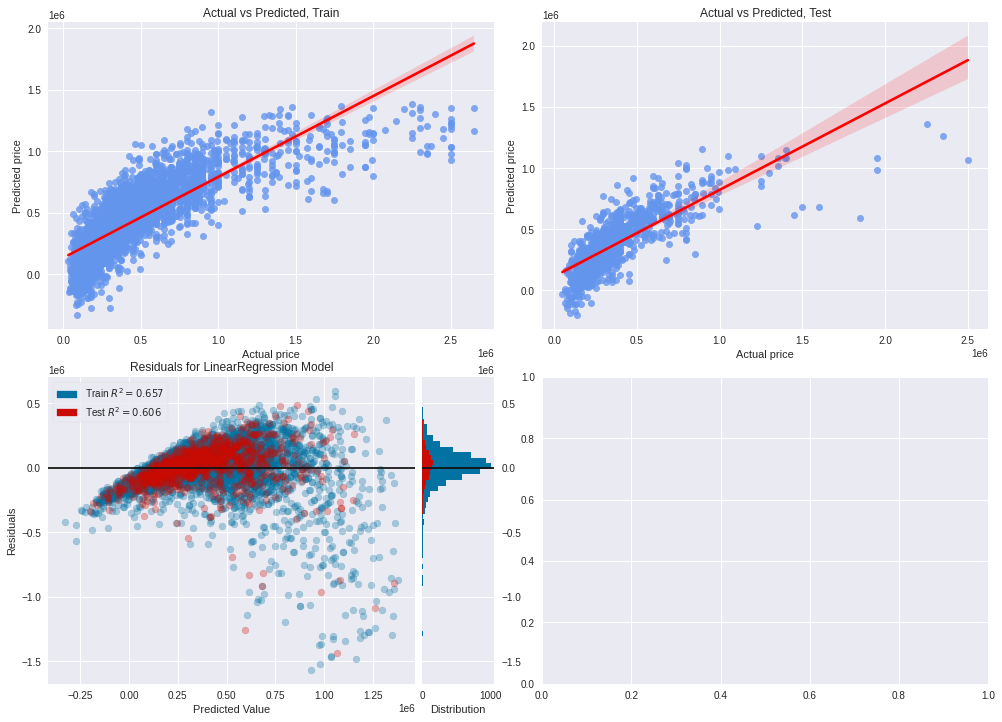

In [13]:
residuals(lr_pipe_estimator, X_train, X_test, y_train, y_test)

Eje x = y _test
Eje y = y_pred
- Predice valores negativos, quedandose corto en las predicciones de los valores mas pequegnos

Residuals = y_pred_train - y_train

- Tiende a quedarse corto en las predicciones cuando estas son altas, es decir, hay casas muy caras a las que el modelo no les da tanto valor.
- 
- No hay overfitting



## Polynomial Regression

In [14]:
poly_pipe_estimator = transformer_estimator(num_transformation='yeo-johnson', 
                                            levels_list=[levels_code, levels_type_house],
                                            regressor=LinearRegression(), 
                                            poly_degree=1)

grid_search = GridSearchCV(estimator=poly_pipe_estimator, 
                           param_grid={'preprocessor__num__poly__degree': range(1, 10)}, 
                           cv=5, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
#grid_search.best_estimator_

{'preprocessor__num__poly__degree': 3}
0.7475043994942953


In [15]:
# pd.DataFrame(grid_search.cv_results_) # plotearlo

In [16]:
poly_pipe_estimator = transformer_estimator(num_transformation='yeo-johnson', 
                                            levels_list=[levels_code, levels_type_house],
                                            regressor=LinearRegression(),
                                            poly_degree=3)

scores = scores_statistics(estimator=poly_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7475043994942953
r2 std: 0.01565574126661351 

MAE mean: -95042.44748391473
MAE std: 2983.3022160909354 

MAPE mean: -0.2761964976680359
MAPE std: 0.008867172610069635 

RMSE mean: -152275.50798551686
RMSE std: 8149.481989066285 



### Overfitting Analysis

In [17]:
poly = poly_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = poly.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = poly.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)


Performance on the training set:
 ----------
R²: 0.7716279698936316
MAE: 90819.78253894637
MAPE: 0.26287242234593095
RMSE: 145297.84478598036

Performance on the test set:
 ----------
R²: 0.7406695101479435
MAE: 84580.92759424279
MAPE: 0.2647359471186111
RMSE: 129867.34779392317



### Residuals Diagnostic

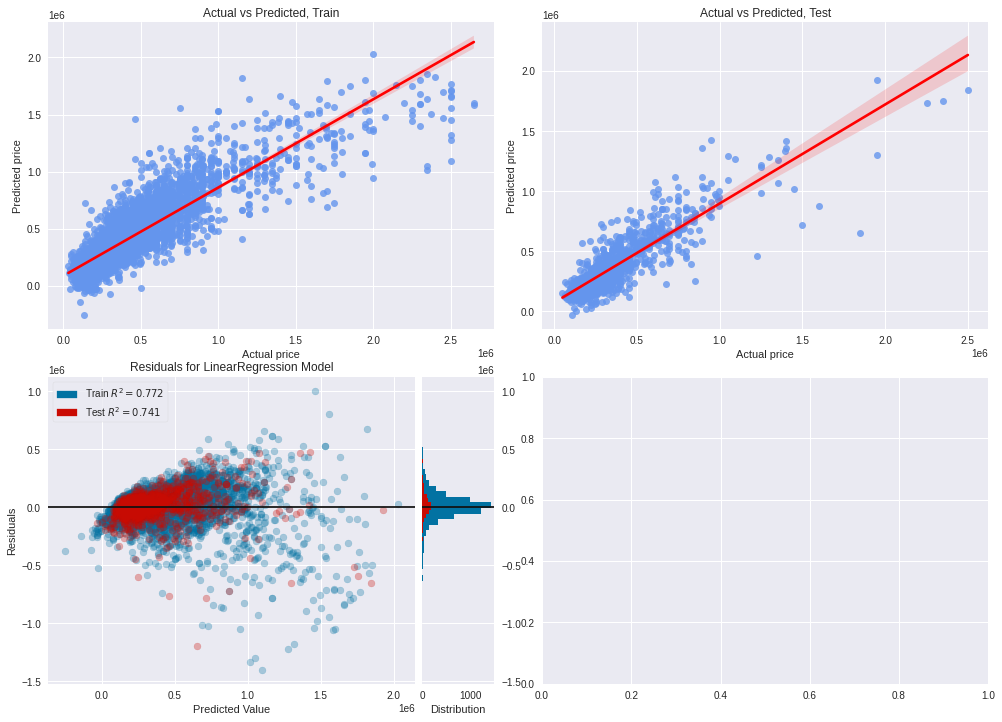

In [18]:
# y_pred_train - y_train
# y_pred_train 
residuals(poly_pipe_estimator, X_train, X_test, y_train, y_test) 

- Se queda corto en algunos valores altos
- Se queda corto en algunos valores muy bajos, llegando a ser predicciones negativas, pero menos que en Linear Regression
- No overfitting

## K Nearest Neighbors Regressor

In [19]:
knnr_pipe_estimator = transformer_estimator(num_transformation='yeo-johnson', 
                                            regressor=KNeighborsRegressor(),
                                            levels_list=[levels_code, levels_type_house],
                                            poly_degree=1)

param_grid = [{
        'preprocessor__num__poly__degree': [1,3],
        'regressor__n_neighbors': [7],  
        'regressor__weights': ['uniform', 'distance'],
        'regressor__leaf_size': [30]
             }]

grid_search = GridSearchCV(estimator=knnr_pipe_estimator, 
                           param_grid=param_grid,
                           cv=3, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'preprocessor__num__poly__degree': 1, 'regressor__leaf_size': 30, 'regressor__n_neighbors': 7, 'regressor__weights': 'distance'}
0.7524463438092918


In [20]:
knnr_pipe_estimator = transformer_estimator(num_transformation='yeo-johnson', 
                                            regressor=KNeighborsRegressor(n_neighbors=7,
                                                                          weights='uniform', # distanc hace que haya mucho overfititng
                                                                          leaf_size= 30), 
                                            levels_list=[levels_code, levels_type_house],
                                            poly_degree=1)

scores = scores_statistics(estimator=knnr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7418281398733264
r2 std: 0.018611308789264206 

MAE mean: -89904.822404627
MAE std: 3245.1154521894887 

MAPE mean: -0.24767287366449992
MAPE std: 0.00823181830716877 

RMSE mean: -153997.83834398555
RMSE std: 9876.196137904775 



### Overfitting Analysis

In [21]:
knnr = knnr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = knnr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = knnr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8150594093691621
MAE: 75984.16764315467
MAPE: 0.20857428371887576
RMSE: 130753.65457606062

Performance on the test set:
 ----------
R²: 0.7457128445280258
MAE: 78811.78428830697
MAPE: 0.2275412838229052
RMSE: 128598.34898832208



### Residuals Diagnostic

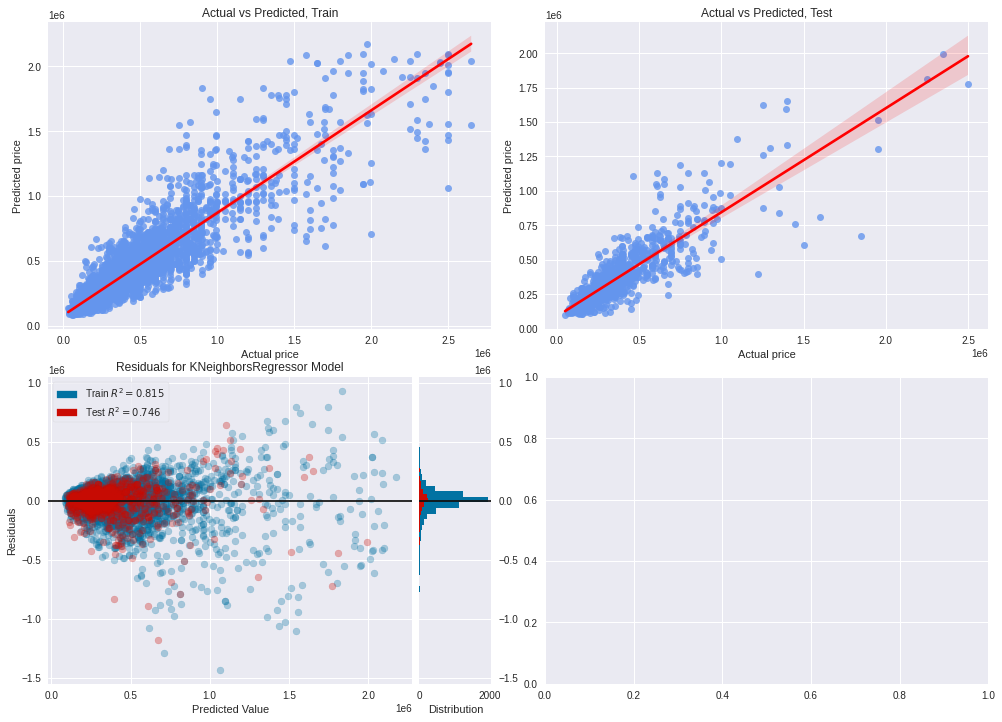

In [22]:
residuals(knnr_pipe_estimator, X_train, X_test, y_train, y_test)

- Se pasa y se queda corto en algunos valores altos de modo que no es tan preciso para valores predichos superiores al millon
- No hay valores negativos
- Se comporta mejor que las anteriores
- No considero overfitting

## Decision Tree Regressor

In [23]:
dtr_pipe_estimator = transformer_estimator(num_transformation='yeo-johnson', 
                                           regressor=DecisionTreeRegressor(),
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=1)

grid_search = GridSearchCV(estimator=dtr_pipe_estimator, 
                           param_grid={
                               'preprocessor__num__poly__degree': [1,3], #[1,2,3,4],
                               'regressor__max_depth': [10,11,12,13,14,15,16,17], #range(5, 15), #[2,3,4,5,6,7]
                               'regressor__min_samples_leaf': [10,11,12,13,14,15, 20, 25, 30], #[1, 3, 5, 10, 20, 50]
                   #            'regressor__min_samples_split': range(35, 45), #[2, 43],
                      #         'regressor__max_leaf_nodes': range(65, 75),
                         #      'regressor__max_features':,
                           }, 
                           cv=5, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


{'preprocessor__num__poly__degree': 3, 'regressor__max_depth': 15, 'regressor__min_samples_leaf': 13}
0.7497715405003904


In [24]:
#pd.DataFrame(grid_search.cv_results_)

In [25]:
dtr_pipe_estimator = transformer_estimator(num_transformation='yeo-johnson', 
                                           regressor=DecisionTreeRegressor(max_depth=13,
                                                                           min_samples_leaf=16,  #16
                                                                       #   min_samples_split=43,
                                                                        #  max_leaf_nodes=68, 
                                                                           random_state=7),
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=3)

scores = scores_statistics(estimator=dtr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7374376512129103
r2 std: 0.027608412668747445 

MAE mean: -92946.82851213228
MAE std: 2903.201976470865 

MAPE mean: -0.25965905122880273
MAPE std: 0.009194946666728043 

RMSE mean: -154962.56958019765
RMSE std: 8130.458208014877 



### Overfitting Analysis

In [26]:
dtr = dtr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = dtr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = dtr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8419118271109391
MAE: 71210.39166037059
MAPE: 0.19881307925123298
RMSE: 120889.17288977934

Performance on the test set:
 ----------
R²: 0.7304362090429639
MAE: 81520.59700085125
MAPE: 0.23698418128726353
RMSE: 132404.869855318



### Residuals Diagnostic

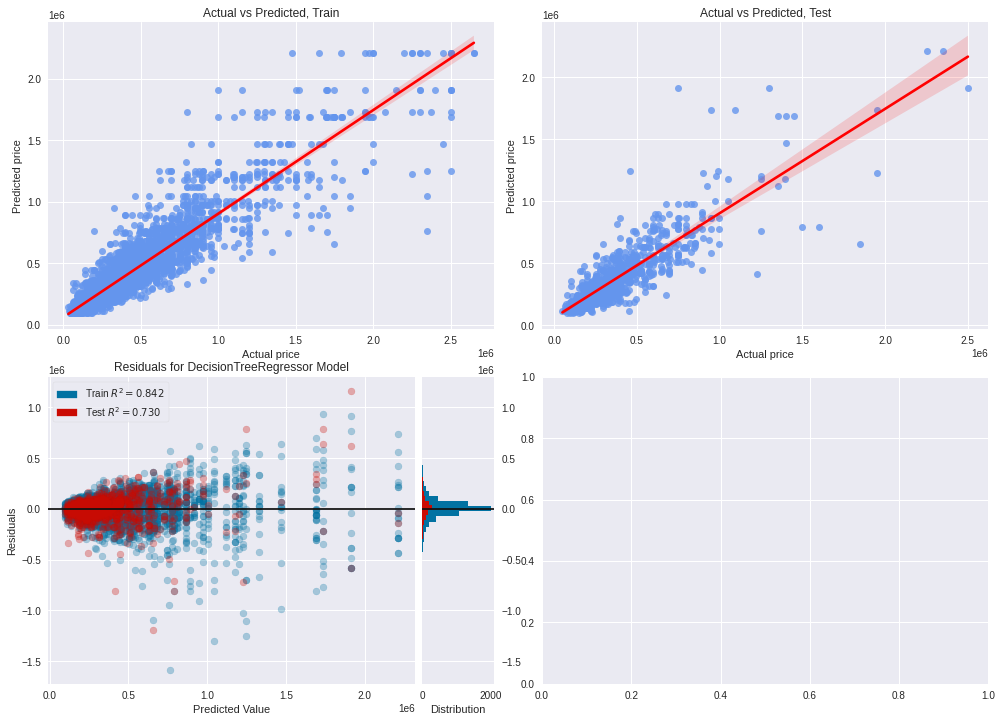

In [27]:
residuals(dtr_pipe_estimator, X_train, X_test, y_train, y_test)

- Menos preciso en valores predichos superiores al millon

## Voting Regressor with Basic Algorithms

In [28]:
scoring_comp = {'r2': 'r2',
                'MAE': 'neg_mean_absolute_error'}

In [29]:
models_r2 = {'poly': 73.41, 'knn': 71.49, 'dt': 73.04}

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'poly': 0.33683582637423143,
 'knn': 0.3280260622189593,
 'dt': 0.33513811140680927}

In [30]:
polyr = poly_pipe_estimator
'''
transformer_estimator(num_transformation='power_transformer', 
                              regressor=LinearRegression(),
                              levels_list=[levels_code, levels_type_house],
                              poly_degree=3)
'''
knnr = knnr_pipe_estimator
'''
transformer_estimator(num_transformation='power_transformer', 
                             regressor=KNeighborsRegressor(n_neighbors=7,
                                                           weights='uniform'), 
                             poly_degree=1)
'''
dtr = dtr_pipe_estimator
'''
transformer_estimator(num_transformation='power_transformer', 
                            regressor=DecisionTreeRegressor(max_depth=9,
                                                            min_samples_leaf=16,  #16
                                                            min_samples_split=43,
                                                            max_leaf_nodes=68),
                            poly_degree=3)
'''

voting_reg = VotingRegressor(
    estimators= [('poly', polyr),
                 ('knn', knnr),
                 ('dt', dtr)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': poly_pipe_estimator, 
               'K Nearest Neighbors Regressor': knnr_pipe_estimator, 
               'Decission Tree Regressor': dtr_pipe_estimator, 
             #  'Random Forest Regressor': rfr,
               'Voting Regressor': voting_reg}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7477406475852575
MAE mean: -94740.95134301903
MAPE mean: -0.27526340820935996
RMSE mean: -151783.5130225027
----------
K Nearest Neighbors Regressor
r2 mean: 0.742996312910319
MAE mean: -89612.19564263737
MAPE mean: -0.2463997356120617
RMSE mean: -153153.74470609083
----------
Decission Tree Regressor
r2 mean: 0.7479040782996138
MAE mean: -90687.91588936331
MAPE mean: -0.25659962635195444
RMSE mean: -151271.74994083782
----------
Voting Regressor
r2 mean: 0.7975850002834377
MAE mean: -80647.81071457635
MAPE mean: -0.2272282291820046
RMSE mean: -135901.9949219459
----------


### Overfitting Analysis

In [31]:
voting_reg.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_reg.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_reg.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8505410357846581
MAE: 69557.41938306301
MAPE: 0.195172468502991
RMSE: 117543.52219740825

Performance on the test set:
 ----------
R²: 0.7969734064274765
MAE: 71477.100023634
MAPE: 0.21453675252820248
RMSE: 114907.83578739919



### Residuals Diagnostic

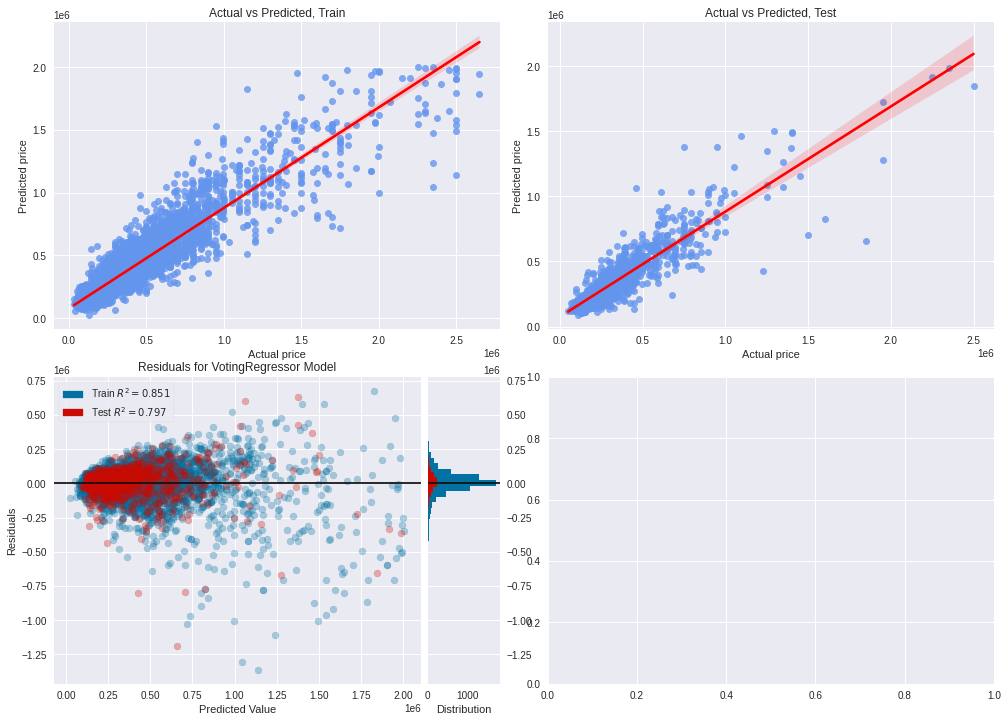

In [32]:
residuals(voting_reg, X_train, X_test, y_train, y_test)

## Random Forest Regressor

### Out-of-bag 

In [33]:
df = data.copy()
y2 = df['price']
X2 = df.drop(columns='price')

preprocessor = ColumnTransformer([
        ('num', PowerTransformer(method='yeo-johnson'), num_features),
        ('cat', OneHotEncoder(), cat_features),
        ]) #, remainder='passthrough' categories=[levels_code, levels_type_house]

X2 = preprocessor.fit_transform(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.15,
                                                        random_state=7)

In [34]:
rfr = RandomForestRegressor(n_estimators=180,
                            min_samples_leaf=10,  
                           # max_features=100,
                            bootstrap=True,
                            oob_score    = True,
                            random_state=7,   
                            n_jobs=-1)
    
rfr.fit(X_train2, y_train2)
print('Train score:', rfr.score(X_train2, y_train2))
print('Out-of-bag score', rfr.oob_score_)

Train score: 0.8587282432377799
Out-of-bag score 0.8006367193520171


### CV

In [35]:
rfr_pipe_estimator = transformer_estimator(num_transformation='yeo-johnson', 
                                           regressor=RandomForestRegressor(
                                               n_estimators=180, 
                                               min_samples_leaf=10,   #16
                                               random_state=7,
                                               bootstrap=True,
                                               n_jobs=-1), 
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=1)

scores = scores_statistics(estimator=rfr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7934250968311602
r2 std: 0.01740848268688333 

MAE mean: -80084.70155617765
MAE std: 3041.9969352342496 

MAPE mean: -0.22725017962018743
MAPE std: 0.007418243550817997 

RMSE mean: -137750.6041688287
RMSE std: 9566.10452524495 



### Overfitting Analysis

In [36]:
rfr = rfr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = rfr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = rfr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8587182297581822
MAE: 65392.47351217628
MAPE: 0.1860003709683132
RMSE: 114282.77573164871

Performance on the test set:
 ----------
R²: 0.7777204787890837
MAE: 71062.0526694331
MAPE: 0.2121560569210422
RMSE: 120232.78512341905



Ahora mismo nuestro modelo hace overfitting, tiene mucha varianza y poco sesgo. No esta aprendiendo bien la relacion entre entre los predictores y la variable respuesta, sino que esta memorizando los datos. Necesitamos buscar un equilibrio optimo entre bias y varianza.

Error total = bias + varianza + e

se pueden obtener las predicciones para las  n  observaciones y con ellas calcular el OOB-mean square error (para regresión)
el OOB-error sirve como estimación del error de test.

### Residuals Diagnostic

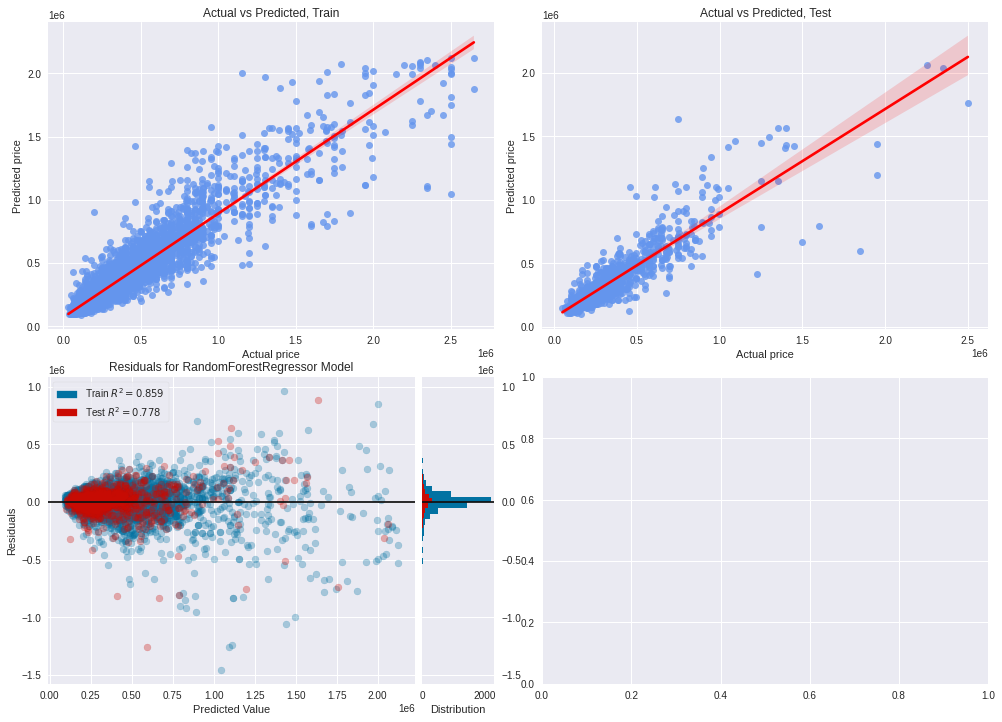

In [37]:
residuals(rfr, X_train, X_test, y_train, y_test)

- Hay overfitting ya que el score en train es muy superior respecto al score en test y los residuos de train se esconden detras de los de test

## Extreme Gradient Boosting

In [38]:
df = data.copy()
y3 = df['price']
X3 = df.drop(columns='price')

preprocessor = ColumnTransformer([
        ('num', PowerTransformer(method='yeo-johnson'), num_features),
        ('cat', OneHotEncoder(), cat_features),
        ]) #, remainder='passthrough' categories=[levels_code, levels_type_house]

X3 = preprocessor.fit_transform(X3)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=.15,
                                                        random_state=7)

xgb3 = XGBRegressor(n_estimators= 300, 
                                           max_depth=3,
                                           learning_rate=.1,
                                           subsample=.25
                   )

eval_set = [(X_test3, y_test3)]
xgb3.fit(X_train3, y_train3, 
            eval_set=[(X_train3, y_train3), (X_test3, y_test3)], 
           # early_stopping_rounds=50
        )

[0]	validation_0-rmse:453858.46875	validation_1-rmse:407035.78125
[1]	validation_0-rmse:417879.43750	validation_1-rmse:373322.31250
[2]	validation_0-rmse:385127.96875	validation_1-rmse:341416.40625
[3]	validation_0-rmse:355672.06250	validation_1-rmse:313810.00000
[4]	validation_0-rmse:330057.06250	validation_1-rmse:289391.81250
[5]	validation_0-rmse:306698.09375	validation_1-rmse:267665.37500
[6]	validation_0-rmse:286240.09375	validation_1-rmse:248507.42188
[7]	validation_0-rmse:268081.65625	validation_1-rmse:231536.37500
[8]	validation_0-rmse:251999.42188	validation_1-rmse:216863.78125
[9]	validation_0-rmse:238578.59375	validation_1-rmse:205284.68750
[10]	validation_0-rmse:226886.07812	validation_1-rmse:194387.87500
[11]	validation_0-rmse:216014.00000	validation_1-rmse:185007.46875
[12]	validation_0-rmse:207417.70312	validation_1-rmse:177402.85938
[13]	validation_0-rmse:198726.10938	validation_1-rmse:170096.68750
[14]	validation_0-rmse:191707.32812	validation_1-rmse:163957.84375
[15]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.25,
             tree_method='exact', validate_parameters=1, verbosity=None)

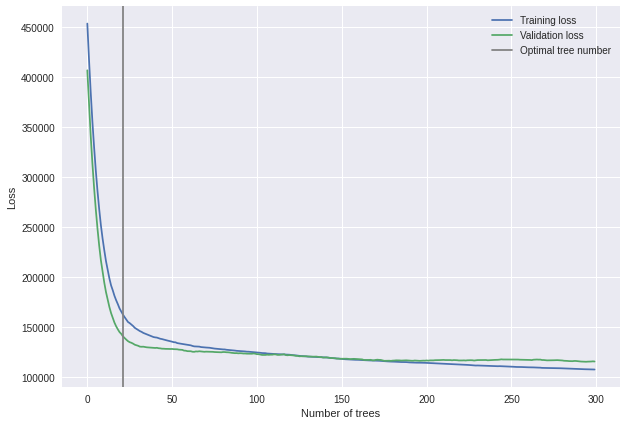

In [39]:
results = xgb3.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

In [40]:
xgb_pipe_estimator = transformer_estimator(num_transformation='yeo-johnson', 
                                           regressor=XGBRegressor(
                                               n_estimators= 177, #150
                                               max_depth=3,
                                               learning_rate=.1,
                                               subsample=.30),
                                           levels_list=[levels_code, levels_type_house],
                                           poly_degree=1)

scores = scores_statistics(estimator=xgb_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.8012243905382925
r2 std: 0.037220808799236046 

MAE mean: -82300.97687253806
MAE std: 4712.640571680671 

MAPE mean: -0.237468313674644
MAPE std: 0.00964037015449505 

RMSE mean: -134288.66652937303
RMSE std: 12739.450348506041 



### Overfitting Analysis

In [41]:
xgb = xgb_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = xgb.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = xgb.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8571721475324723
MAE: 74840.05653987103
MAPE: 0.22504862608920886
RMSE: 114906.3869821748

Performance on the test set:
 ----------
R²: 0.7910316768408792
MAE: 72701.63284085754
MAPE: 0.22187505127996696
RMSE: 116577.14361247883



### Residuals Diagnostic

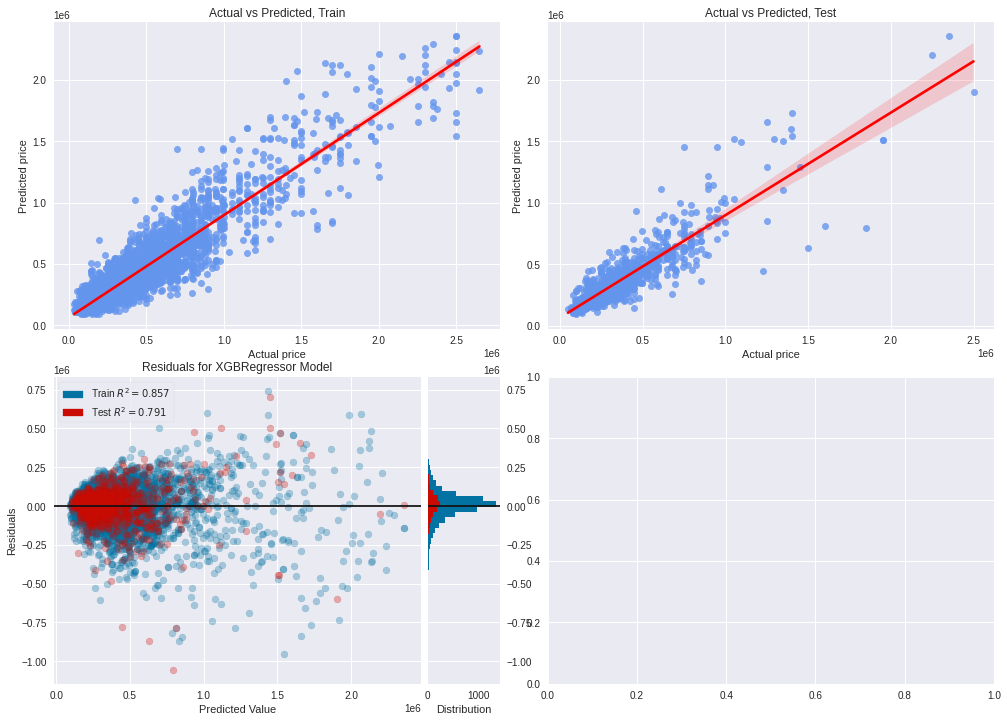

In [42]:
residuals(xgb_pipe_estimator, X_train, X_test, y_train, y_test)

## Voting Regressor with Ensemble Methods

In [43]:
models_r2 = {'poly': 73.41, 'rfr': 80.92, 'xgb': 79.92} 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'poly': 0.3133831376734258,
 'rfr': 0.34544290288153684,
 'xgb': 0.34117395944503737}

In [44]:
polyr = poly_pipe_estimator
rfr = rfr_pipe_estimator
egb = xgb_pipe_estimator

voting_regressor1 = VotingRegressor(
    estimators= [('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor1}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7477406475852575
MAE mean: -94740.95134301903
----------
Random Forest Regressor
r2 mean: 0.7961359069662776
MAE mean: -79425.07710487487
----------
XGBoost
r2 mean: 0.8012243905382925
MAE mean: -82300.97687253806
----------
Voting Regressor
r2 mean: 0.8071241229968148
MAE mean: -79161.8391344653
----------


In [45]:
voting_regressor1.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor1.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor1.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8532476642697723
MAE: 71066.18304452834
MAPE: 0.20474001475169903
RMSE: 116474.3317051961

Performance on the test set:
 ----------
R²: 0.7994735778882222
MAE: 70147.72511270642
MAPE: 0.21393288513546072
RMSE: 114198.12768748584



Y si en lugar de usar el Polynomial Regression usamos el Voting Regressor with Basic Algorithms?

In [46]:
models_r2 = {'voting_reg': 77.81, 'rfr': 80.92, 'xgb': 79.92} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'voting_reg': 0.3260423213911586,
 'rfr': 0.3390739576786088,
 'xgb': 0.3348837209302325}

In [47]:
voting_reg = voting_reg
rfr = rfr_pipe_estimator
egb = xgb_pipe_estimator

voting_regressor2 = VotingRegressor(
    estimators= [('voting_reg', voting_reg),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_reg, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor2}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7975850002834377
MAE mean: -80647.81071457635
----------
Random Forest Regressor
r2 mean: 0.7961359069662776
MAE mean: -79425.07710487487
----------
XGBoost
r2 mean: 0.8012243905382925
MAE mean: -82300.97687253806
----------
Voting Regressor
r2 mean: 0.8131971156165927
MAE mean: -77260.76273254043
----------


In [48]:
voting_regressor2.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor2.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor2.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8677629837014993
MAE: 66710.81746328676
MAPE: 0.19272909531626017
RMSE: 110564.12592798308

Performance on the test set:
 ----------
R²: 0.8046592389202757
MAE: 68329.21925975189
MAPE: 0.20691998815971288
RMSE: 112711.86055463093



y sin ninguno?

In [49]:
models_r2 = {'rfr': 80.92, 'xgb': 79.92} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'rfr': 0.5031086794329769, 'xgb': 0.4968913205670231}

In [50]:
#polyr = poly_pipe_estimator
rfr = rfr_pipe_estimator
egb = xgb_pipe_estimator

voting_regressor3 = VotingRegressor(
    estimators= [#('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {#'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor3}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Random Forest Regressor
r2 mean: 0.7961359069662776
MAE mean: -79425.07710487487
----------
XGBoost
r2 mean: 0.8012243905382925
MAE mean: -82300.97687253806
----------
Voting Regressor
r2 mean: 0.8088864089925172
MAE mean: -78633.05045823575
----------


In [51]:
voting_regressor3.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor3.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor3.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8669744414935541
MAE: 68198.85792923762
MAPE: 0.20038001020617754
RMSE: 110893.28827643086

Performance on the test set:
 ----------
R²: 0.7948601008715057
MAE: 69633.26533973952
MAPE: 0.21105294641851366
RMSE: 115504.32591280148



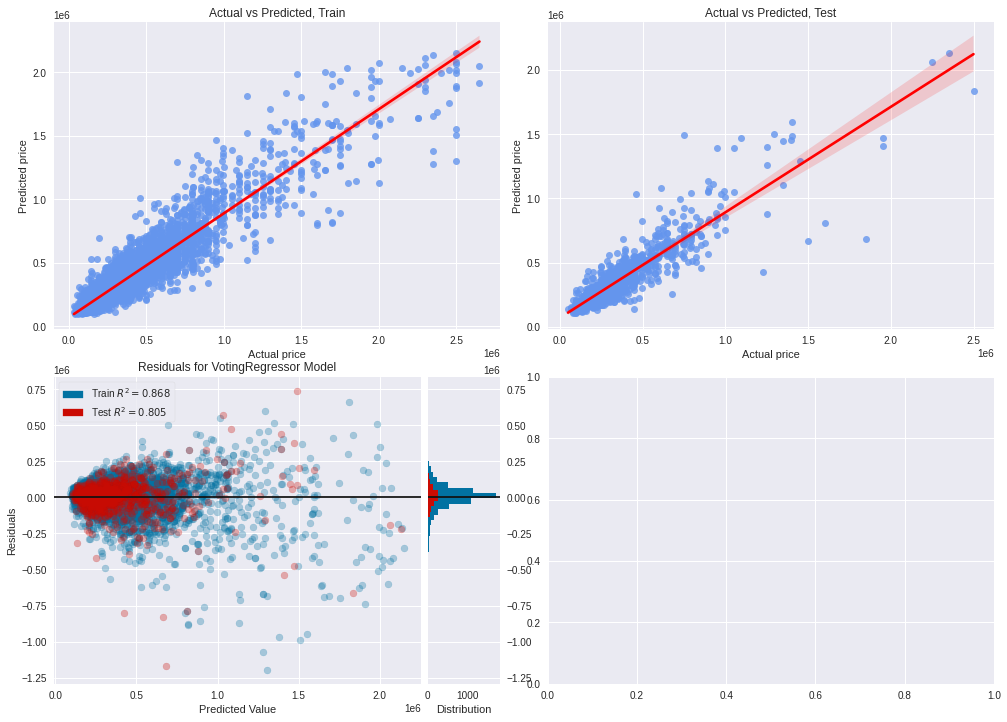

In [52]:
residuals(voting_regressor2, X_train, X_test, y_train, y_test)

## Stacking

Regression Meta-Model: Linear Reagression

In [53]:
from sklearn.ensemble import StackingRegressor

In [54]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('polyr', poly_pipe_estimator))
    level0.append(('rfr', rfr_pipe_estimator))
    level0.append(('egb', xgb_pipe_estimator))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [55]:
models_dict = {'Polynomial Regression': poly_pipe_estimator, 
               'Random Forest Regressor': rfr_pipe_estimator, 
               'XGBoost': xgb_pipe_estimator,
               'Stacking': get_stacking()}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7477406475852575
MAE mean: -94740.95134301903
----------
Random Forest Regressor
r2 mean: 0.7961359069662776
MAE mean: -79425.07710487487
----------
XGBoost
r2 mean: 0.8012243905382925
MAE mean: -82300.97687253806
----------
Stacking
r2 mean: 0.8093192913786755
MAE mean: -78774.43042368034
----------


In [56]:
stacking = get_stacking()
stacking.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = stacking.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = stacking.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8644319957629008
MAE: 69854.35612309247
MAPE: 0.20133893719092452
RMSE: 111947.99441622883

Performance on the test set:
 ----------
R²: 0.7978432719112003
MAE: 69767.82918625935
MAPE: 0.20808058537240998
RMSE: 114661.4107951226



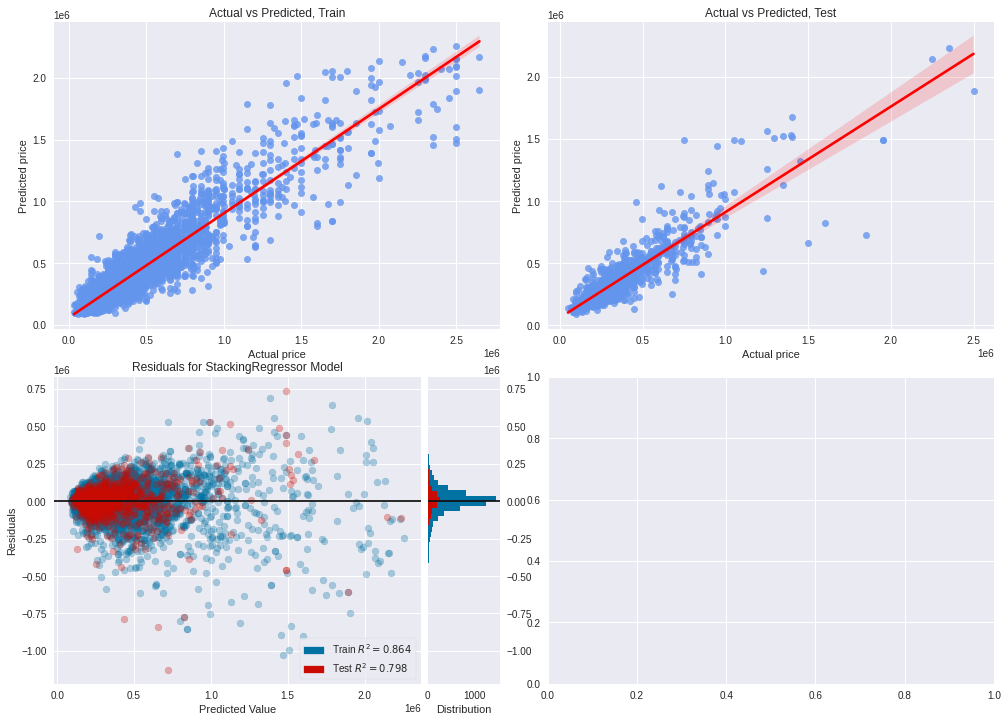

In [57]:
residuals(stacking, X_train, X_test, y_train, y_test)

# Dataset to try the frontend:

In [58]:
srthrsg

NameError: name 'srthrsg' is not defined

In [ ]:
X_test.shape, y_test.shape, y_pred.shape

In [ ]:
X_test.sample()

In [ ]:
y_test.sample()

In [ ]:
y_pred = pd.Series(y_pred.copy())
y_pred.sample()

In [ ]:
X_test.isna().sum()

In [ ]:
y_test.isna().sum()

In [ ]:
y_pred.isna().sum()

In [ ]:
y_pred.head(5)

In [ ]:
X_test.head()

In [ ]:
y_test.head()

In [ ]:
data.columns

In [ ]:
X = data[['floor_area', 'latitude', 'longitude', 
          'bedroom', 'bathroom', 'type_house', 'code']].copy()
y = data['price']

#data_to_frontend = X.copy()
#data_to_frontend['price'] = y.copy()

data_to_frontend = data.copy()
xgb = xgb_pipe_estimator.fit(X_train, y_train)

y_pred = xgb.predict(X)

data_to_frontend['inferred_price'] = list(y_pred) # me daba muchos nan si lo unia siendo una series
data_to_frontend['difference'] = data_to_frontend.inferred_price - data_to_frontend.price
data_to_frontend.sample()

In [ ]:
data_to_frontend.isna().sum()

In [ ]:
data_to_frontend.difference.head()

In [ ]:
print(data_to_frontend.difference.min())
print(data_to_frontend.difference.max())    
print(data_to_frontend.difference.mean())    

In [ ]:
print(data_to_frontend.loc[data_to_frontend.difference > 0, 'difference'].max())
print(data_to_frontend.loc[data_to_frontend.difference > 0, 'difference'].min())

In [ ]:
print(data_to_frontend.loc[data_to_frontend.difference < 0, 'difference'].max())
print(data_to_frontend.loc[data_to_frontend.difference < 0, 'difference'].min())

In [ ]:
nan_array = np.empty(data_to_frontend.shape[0])
nan_array[:] = np.NaN
nan_ser = pd.Series(nan_array)
nan_ser.shape

In [ ]:
data_to_frontend['dif_per'] = nan_ser
data_to_frontend.sample()

In [ ]:
max_pos = data_to_frontend.loc[data_to_frontend.difference > 0, 'difference'].max()
max_neg = data_to_frontend.loc[data_to_frontend.difference < 0, 'difference'].min()

def difference_percentage(dif):
    
    if dif > 0:
        result = dif / max_pos
    elif dif < 0:
        result = -(dif / max_neg)
        
    return result

In [ ]:
for i, row in data_to_frontend.iterrows():
    #print(row.difference)
    
    dif_per = difference_percentage(row.difference)
        
    data_to_frontend.loc[i, 'dif_per'] = dif_per
    

In [ ]:
data_to_frontend.sample()

In [ ]:
data_to_frontend.isna().sum()

In [ ]:
data_to_frontend.to_csv('FrontEnd/data_predicted.csv', sep=',', index=False)